# Lernziel 4 - Variational Auto Encoder
In diesem Lernziel soll sich mit generativen Verfahren beschäftigt werden. Hier wurde sich für ein Variational Auto Encoder entschieden, der Gesichter generieren soll.

Der verwendete Datensatz stammt von [KomNET: Face Image Dataset from Various Media](https://data.mendeley.com/datasets/hsv83m5zbb/2). Außerdem wurde sich an folgenden Links für eine Implementierung orientiert:
> 1. [Tensorflow](https://www.tensorflow.org/tutorials/generative/cvae)
> 2. [Keras](https://keras.io/examples/generative/vae/)
> 3. [Humbolt-Universität zu Berlin](https://humboldt-wi.github.io/blog/research/information_systems_1819/generativemodels/)


## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Optional: Für Google Colab Notebooks

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
# os.chdir("/content/drive/MyDrive/Colab Notebooks/Abgabe_AML")

Mounted at /content/drive/


## Datensatz
Der eingelesene Datensatz besteht aus circa 1200 Bildern. Die Bilder stellen Männer und Frauen mit asiatischer Herkunft in Porträt Ansicht dar. Jede Person wurde aus verschiednen Winkeln im Porträt fotographiert.
Die Bilder sind 224 x 224 Pixel groß und sind in RGB Farben.

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/Colab Notebooks/Abgabe_AML/images/',
  validation_split=None,
  labels=None,
#   subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1195 files belonging to 1 classes.


## Netzwerk
Der Variational Auto Encoder (VAE) besteht aus einem dreiteiligen Netzwerk. Der erste Teil des Netzwerkes nennt sich *Encoder*, der zweite Teil ist für eine weitere Verarbeitung zuständig und wird hier *Sampling* genannt. Der dritte Teil nennt sich *Decoder*. Die Einzelnen Komponenten werden im Folgenden erläutert.

### Sampling
Durch das Sampling Layer entsteht die komprimierte Darstellung des Inputs. Durch den Output des Encoder Netzwerkes erstellt dieses Netzwerk über eine Normalverteilung den Input für das Decoder Netzwerk. 

In [5]:
class Sampling(layers.Layer):
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder
Das Encoder Netzwerk bekommt als Input ein Bild mit den Maßen 224 x 224 und drei Farbchannels. Der Encoder versucht nun dieses Input durch meherere Convolutional Layer in eine niedrigere Dimension zu komprimieren. Der Output dieses Netzwerkes sind zwei Vektoren, der Durchschnitt und der Logarithmus der Varianz.

In [33]:
latent_dim = 32

encoder_inputs = keras.Input(shape=(224, 224, 3))
# x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 112, 112, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 56, 56, 128)  73856       conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 401408)       0           conv2d_6[0][0]                   
____________________________________________________________________________________________

### Decoder
Das Decoder Netzwerk dekomprimiert den Output des Encoder Netzwerkes und Sampling Layers wieder zurück in ein Bild mit den Maßen 224 x 224 und drei Farbchannels. Die Architektur dieses Netzwerkes ist in umgekehrter Reihenfolge fast identisch zu dem Encoder Netzwerk. 

In [36]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(56 * 56 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((56, 56, 64))(x)
# x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 200704)            6623232   
_________________________________________________________________
reshape_2 (Reshape)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 224, 64)      73792     
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 224, 224, 3)       1731      
Total params: 6,772,611
Trainable params: 6,772,611
Non-trainable params: 0
_________________________________________________

### Kombination von Encoder, Sampling und Decoder
Diese drei Komponenten gemeinsam ergeben den VAE.

Da der Loss eines VAE bestimmt wird, indem das Eingangsbild mit dem Ausgangsbild verglichen wird, ist hier eine eigene Funktion für einen Trainingsschritt implementiert worden. In diesem Schritt ist eine Loss Funktion implementiert, die zwei Loss Werte kombiniert:
> 1. *Reconstruction Loss*
> 2. *Kullback-Leibler Loss*, oder auch *KL Loss*

Der Reconstruction Loss sagt dabei aus wie weit das Eingangsbild und das Ausgangsbild von einander abweichen. Der KL Loss dagegen wird dazu verwendet, um aussagen zukönnen, wie weit der Output des Sampling Layers von einer Normalverteilung abweicht. So kann der VAE dahingehend trainiert werden, dass eine geringe Abweichung zwischen Input und Output aufzuweisen.





In [37]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Training
Für das Training wurde der Trainingsdatensatz normalisiert. Ohne Normalisierung könnte beobachtet werden, dass die erzeugten Bilder nur weiß waren. Der Loss spiegelte dies in *NaN* Werten wieder. Der VAE wurde für über 500 Epochen trainiert.

In [38]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x: (normalization_layer(x)))

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(0.001))

In [50]:
vae.fit(normalized_ds, epochs=100, batch_size=128)

Epoch 1/100
38/38 [==============================] - 5s 115ms/step - loss: 30511.2086 - reconstruction_loss: 30408.3594 - kl_loss: 71.4975
Epoch 2/100
38/38 [==============================] - 5s 116ms/step - loss: 30462.4019 - reconstruction_loss: 30408.2129 - kl_loss: 71.4190
Epoch 3/100
38/38 [==============================] - 5s 114ms/step - loss: 30435.3811 - reconstruction_loss: 30381.9766 - kl_loss: 71.4651
Epoch 4/100
38/38 [==============================] - 5s 117ms/step - loss: 30469.4512 - reconstruction_loss: 30384.0586 - kl_loss: 71.4532
Epoch 5/100
38/38 [==============================] - 5s 114ms/step - loss: 30451.8797 - reconstruction_loss: 30387.5098 - kl_loss: 71.1588
Epoch 6/100
38/38 [==============================] - 5s 115ms/step - loss: 30495.6753 - reconstruction_loss: 30426.1406 - kl_loss: 71.0630
Epoch 7/100
38/38 [==============================] - 5s 115ms/step - loss: 30558.9260 - reconstruction_loss: 30446.5586 - kl_loss: 70.6025
Epoch 8/100
38/38 [========

## Evaluation
Nach einigen Trainingsepochen kann evaluiert werden. Hierzu kann zufälliger normalverteilter Verktor mit den Abmaßen des Latenten-Vektors  in *z_sample* gesetzt werden. Diese Werte werden in den Decoder gegeben welcher einen Array ausgibt. Dieser Array kann mit Hilfe der Bilbliothek *matplotlib* visualisiert werden.

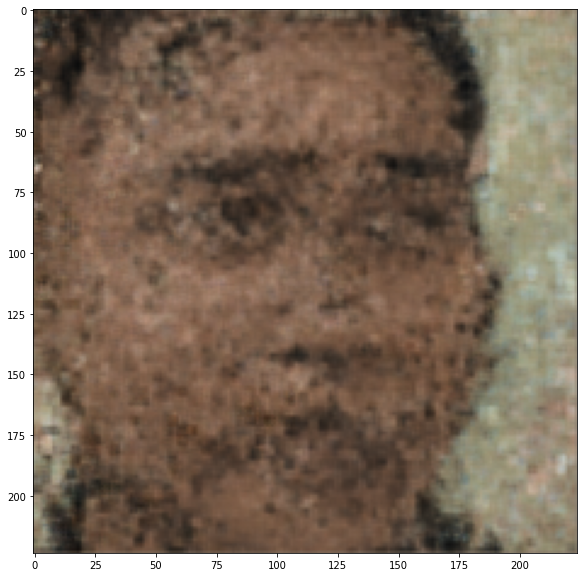

In [49]:
z_sample = np.array([np.random.normal(loc=0.0, scale=1.0, size=(32,))])
x_decoded = vae.decoder.predict(z_sample)
face = x_decoded[0].reshape(224, 224, 3)
plt.figure(figsize = (10,10))
plt.imshow(face,)

## Fazit
Im Laufe des Trainings wurden verschiedene Encoder und Decoder Architekturen getestet. Dabei ist aufgefallen, dass bei zu wenigen Convolutional Layern das Bild sehr verpixelt wirkt. Bei zu vielen Layern hingegen wirkt das Bild sehr unscharf und veschwommen. 